### Desafío - Inferencia de tópicos con EM

* Para realizar este desafío debes haber revisado la lectura y videos correspondiente a la unidad.
* Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook y csv).
* Una vez terminado el desafío, comprime la carpeta y sube el .zip

### Descripción
* En esta sesión trabajaremos con una serie de base de datos sobre letras musicales de distintos artistas. Cada uno de los csv se encuentra en la carpeta dump.
* Cada csv tiene el nombre del artista a analizar. Los archivos contienen el nombre del artista, el género musical del artista, el nombre de la canción y las letras.
* En base a esta información, el objetivo del ejercicio es generar un modelo probabilístico que pueda identificar el género musical más probable dado la letra de una canción. Para ello implementaremos un modelo conocido como Latent Dirichlet Allocation que hace uso de una variante del algoritmo EM para inferir clases latentes a partir de una matriz de documentos.

### Ejercicio 1: Preparar el ambiente de trabajo
* Importe los módulos numpy , pandas , matplotlib , seaborn , glob y os siguiendo las buenas prácticas. Los últimos dos módulos permitirán realizar la importación de múltiples archivos dentro de la carpeta dump .
* Para ello genere un objeto que guarde en una lista todos los archivos alojados en dump utilizando glob.glob y os.getcwd() para extraer las rutas absolutas. Posteriormente genere un objeto pd.DataFrame que contenga todos los csv.
* Asegúrese de eliminar la columna Unnamed: 0 que se genera por defecto.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import warnings

warnings.filterwarnings(action='ignore')

In [2]:
dfs = list(map(lambda path: pd.read_csv(os.getcwd() + '/' + path), glob.glob('files/dump/*')))
df = pd.concat(dfs).drop(columns=['Unnamed: 0', '1'])
df.columns = ['artist', 'song', 'lyrics']
df.head()

,artist,song,lyrics
0,The Beatles,I Saw Her Standing There,"One, two, three, four! \n Well, she was just s..."
1,The Beatles,Misery,The world is treating me bad \n Misery \n I'm ...
2,The Beatles,Anna (Go To Him),"Anna \n You come and ask me, girl \n To set yo..."
3,The Beatles,Chains,Chains \n My baby's got me locked up in chains...
4,The Beatles,Boys,I've been told when a boy kiss a girl \n Take ...


### Ejercicio 2: Matriz de ocurrencias
* Importe la clase CountVectorizer dentro de los módulos feature_extraction.text de la librería sklearn .
* Aplique la clase para extraer las 5000 palabras más repetidas en toda la base de datos.
* Con la clase inicializada, incorpore las letras con el método fit_transform y guarde los resultados en un nuevo objeto

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
count_vectorizer = CountVectorizer(stop_words='english', max_features=5000)
lyrics_count = count_vectorizer.fit_transform(df['lyrics'])
tokens = lyrics_count.toarray()

### Ejercicio 3: Entrenamiento del Modelo
* Importe sklearn.decomposition.LatentDirichletAllocation y sklearn.model_selection.GridSearchCV .
* Genere una búsqueda de grilla con los siguientes hiperparámetros:
    * n_components: [5, 10, 15] .
    * learning_decay: [0.7, 0.5] .
* Entrene la búsqueda de grilla con las letras en un formato vectorizado con CountVectorizer .
* Reporte brevemente cuál es la mejor combinación de hiperparámetros

##### Digresión: Latent Dirichlet Allocation
* Latent Dirichlet Allocatio (LDA) es un modelo probabilístico generativo basado en Inferencia Variacional EM. La principal utilidad de éste es la identificación de tópicos en un corpus de texto. 
* El proceso de inferencia se puede resumir en los siguientes pasos:
    * Cada documento dentro del corpus se puede entender como una mezcla de tópicos comunes a nivel de corpus.
    * Esta mezcla de tópicos es latente $\leadsto$ Sólo observamos los documentos registrados y sus palabras. La API de sklearn.decomposition.LatentDirichletAllocation presenta la misma funcionalidad de todo modelo de sklearn. Algunos puntos a considerar en la inicialización de la clase son:
        * n_components : Cantidad de tópicos a inferir en un corpus.
        * learning_method : Forma en la que entran los datos en entrenamiento. Cuando es 'batch' , se ingresa la matriz de entrenamiento completa. Cuando es 'online' , la matriz de entrenamiento ingresa de manera secuencial en parcelas pequeñas.
        * learning_decay : Tasa de aprendizaje en la función de pérdida. Cuando se implementa con learning_method='online', el modelo se entrena con Gradiente Estocástico Descendente.
        * Perplejidad: Busca aproximar el número óptimo de tópicos a inferir. Técnicamente evalúa qué tan bien predice una muestra específica. En funcion a un número de tópicos, define la distribución teórica de palabras representada por los tópicos y la compara con la ocurrencia empírica de palabras en tópicos

In [16]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

In [21]:
params = {
    'n_components': [5, 10, 15],
    'learning_decay': [0.7, 0.5],
}

cv = GridSearchCV(LatentDirichletAllocation(learning_method='online'), params, cv=3)

In [22]:
result = cv.fit(tokens)

In [27]:
best_learning_decay = result.best_params_['learning_decay']
best_n_components = result.best_params_['n_components']
print('La mejor combinación de hiperparámetros es learning_decay = {} y n_components = {}'.format(best_learning_decay, best_n_components))

La mejor combinación de hiperparámetros es learning_decay = 0.5 y n_components = 5


### Ejercicio 4 : Inferencia e Identificación de Tópicos
* En base a la mejor combinación de hiperparámetros, entrene el modelo con la matriz de atributos de las letras.
* Para identificar de qué se trata cada tópico, necesitamos identificar las principales 15 palabras asociadas con éste. Puede implementar la siguiente línea de código para identificar las principales palabras en un tópico:

```python
# mediante .components_ podemos extraer una matriz que entrega las distribución de palabras por cada tópico.

for topic_id, topic_name in enumerate(fit_best_lda.components_):
    # para cada tópico
    print("tópico: {}".format(topic_id + 1))
    # mediante argsort logramos ordenar los elementos por magnitud
    # para los elementos más relevantes ordenados por argsort, buscamos su correlativo
    # en la matriz dispersa y devolvemos el nombre.
    # finalmente concatenamos las palabras
    print(" ".join([counter.get_feature_names()[i] for i in topic_name.argsort()[:-15 - 1: -1]]))
```

* Comente a qué tópicos está asociada cada clase inferida.

In [33]:
counter = count_vectorizer
fit_best_lda = result.best_estimator_

for topic_id, topic_name in enumerate(fit_best_lda.components_):
    # para cada tópico
    print("\ntópico: {}".format(topic_id + 1))

    # mediante argsort logramos ordenar los elementos por magnitud
    # para los elementos más relevantes ordenados por argsort, buscamos su correlativo
    # en la matriz dispersa y devolvemos el nombre.
    # finalmente concatenamos las palabras
    print(" ".join([counter.get_feature_names()[i] for i in topic_name.argsort()[:-30 - 1: -1]]))


tópico: 1
like got shit ain man fuck em yo nigga ya rock cause bitch know niggas ass don yeah come big let real just hit uh new money ll right fuckin

tópico: 2
life die blood world god dead death man soul black eyes kill hell pain live war end face head fight lord fear mind inside power left time born earth land

tópico: 3
yeah oh baby hey ooh ah gonna let come la got girl love wanna right ha want know dance whoa ya good make like gotta mama little just stop da

tópico: 4
love ll like ve away time way day feel heart just night come know let oh long home got eyes won hold little gone good make light sun life don

tópico: 5
don know just say want cause think tell time make got right ll gonna need wanna said people ve really man better like life look gotta did going stop bad


En base a las letras, yo diría lo siguiente:

- tópico 1: hip hop
- tópico 2: metal
- tópico 3: pop
- tópico 4: emo
- tópico 5: rock

### Ejercicio 5: Identificación de probabilidades
* En base a la información generada, es posible identificar cuales van a ser los géneros más probables de ocurrir para un artista.
* Para ello necesitamos guardar la probabilidad de cada canción en nuestra base de datos original. 
* Podemos implementar esto de la siguiente manera:
    
```python    
# generamos una transformación de los datos a distribución de tópico por palabra en el documento
fit_best_lda = best_lda.transform(transformed_feats)
# estra transformación la podemos coercionar a un dataframe de la siguiente manera
topics_for_each_doc = pd.DataFrame(
                                    # pasamos esta matriz y la redondeamos en 3 decimales
                                    np.round(fit_best_lda, 3),
                                    # agregamos un índice
                                    index=df_lyrics.index
                                    )
#agregamos identificadores de columna
topics_for_each_doc.columns = list(map(lambda x: "T: {}".format(x), range(1, best_lda.n_components + 1)))
# concatenamos las probabilidades de tópico por documento a nuestra matriz original
concatenated_df = pd.concat([df_lyrics, topics_for_each_doc], axis=1)
# argmax en la matriz de tópicos
concatenated_df['highest_topic'] = np.argmax(docs_topics.values, axis=1) + 1   

```

* Genere una matriz de correlaciones entre la probabilidad de tópicos inferidos. Comente brevemente cuales son las principales asociaciones existentes.

* Con esta nueva base de datos, identifique las probabilidades de pertenencia para un artista específico.

* Grafique la distribución de las probabilidades para algún artista en específico.

In [35]:
transformed_feats = tokens
best_lda = result.best_estimator_

# generamos una transformación de los datos a distribución de tópico por palabra en el documento
what = best_lda.transform(transformed_feats)

# estra transformación la podemos coercionar a un dataframe de la siguiente manera
topics_for_each_doc = pd.DataFrame(
                                    # pasamos esta matriz y la redondeamos en 3 decimales
                                    np.round(what, 3),
                                    # agregamos un índice
                                    index=df.index
                                    )

#agregamos identificadores de columna
topics_for_each_doc.columns = list(map(lambda x: "T: {}".format(x), range(1, best_lda.n_components + 1)))
# concatenamos las probabilidades de tópico por documento a nuestra matriz original
concatenated_df = pd.concat([df, topics_for_each_doc], axis=1)
# argmax en la matriz de tópicos
concatenated_df['highest_topic'] = np.argmax(topics_for_each_doc.values, axis=1) + 1   

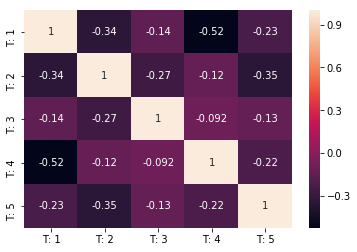

In [42]:
sns.heatmap(concatenated_df.loc[:, 'T: 1':'T: 5'].corr(), annot=True);

Las principales asociaciones existentes son:
    
- Entre T1 y T4
- Entre T1 y T2
- Entre T3 y T2

Aunque todas estas son correlaciones negativas.

Vamos a ver las probabilidades para el artista Radiohead:

In [48]:
artist = 'Radiohead'
radiohead_df = concatenated_df[concatenated_df['artist'] == artist]

In [59]:
radiohead_df['highest_topic'].value_counts('%')

4    0.410596
5    0.258278
2    0.178808
1    0.099338
3    0.052980
Name: highest_topic, dtype: float64

Podemos ver que la probabilidad de pertenencia al tópico 4 es de 41%, y le sigue el tópico 5 con un 25%.

Y si graficamos esto:

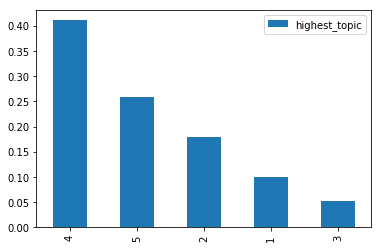

In [72]:
radiohead_df['highest_topic'].value_counts(normalize=True).to_frame().plot.bar();

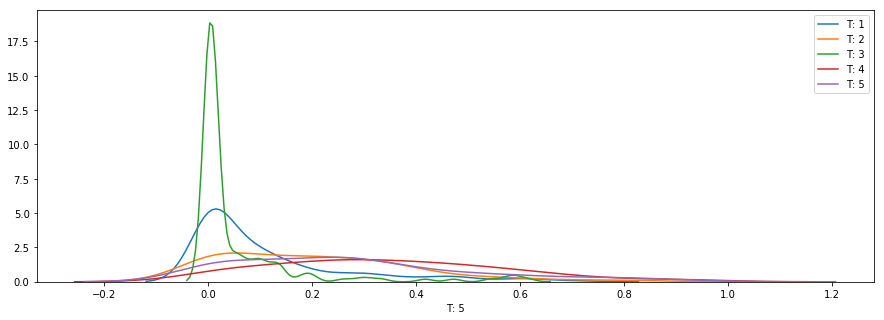

In [74]:
plt.figure(figsize=(15, 5))

for col_name in radiohead_df.loc[:, 'T: 1':'T: 5']:
    sns.distplot(radiohead_df[col_name], hist=False, label=col_name)
    plt.legend()

Podemos ver que T4 tiene una distribución con valores más grandes, corroborando lo que dice el gráfico anterior.